In [1]:
#import libraries
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import plotnine as p9
import seaborn as sns
import xgboost as xgb
import time
from xgboost import XGBClassifier
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
from sklearn.model_selection import train_test_split
from sklearn import linear_model, tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from scipy.stats import mode
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import StandardScaler,MinMaxScaler,LabelEncoder
from sklearn.metrics import mean_squared_error,r2_score,confusion_matrix,classification_report
from sklearn.datasets import make_blobs
from sklearn.tree import DecisionTreeClassifier
from cycler import cycler
from scipy.stats import pearsonr
import warnings
warnings.filterwarnings('ignore')
from imblearn.over_sampling import SMOTE
oversampling_instance = SMOTE(k_neighbors = 3)

In [2]:
after_vif = pd.read_csv("after_vif.csv")
after_vif.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4687 entries, 0 to 4686
Data columns (total 16 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Absolute Magnitude           4687 non-null   float64
 1   Est Dia in M(min)            4687 non-null   float64
 2   Orbit ID                     4687 non-null   int64  
 3   Orbit Uncertainity           4687 non-null   int64  
 4   Minimum Orbit Intersection   4687 non-null   float64
 5   Epoch Osculation             4687 non-null   float64
 6   Eccentricity                 4687 non-null   float64
 7   Inclination                  4687 non-null   float64
 8   Asc Node Longitude           4687 non-null   float64
 9   Orbital Period               4687 non-null   float64
 10  Perihelion Arg               4687 non-null   float64
 11  Mean Anomaly                 4687 non-null   float64
 12  Mean Motion                  4687 non-null   float64
 13  hazar_bool        

In [3]:
### X and Y for after VIF:
X_avif = after_vif.loc[:, ~after_vif.columns.isin(['hazar_bool'])]
Y_avif = after_vif['hazar_bool'] 

#### Train test split without Oversampling Method:


In [4]:
X_train, X_test, y_train, y_test = train_test_split(X_avif, Y_avif, random_state=0)

In [5]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaler.fit_transform(X_train)
X_train = scaler.fit_transform(X_train)

#### Train test split with Oversampling Method:

In [6]:
oversampling_instance = SMOTE(k_neighbors = 3)

#apply oversampling
X_train2, y_train2 = oversampling_instance.fit_resample(X_train, y_train)
y_train2.value_counts()
X_train_ovs, X_test_ovs, y_train_ovs, y_test_ovs = train_test_split(X_train2, y_train2, random_state=0)
pd.DataFrame(X_train2).to_csv('X_train_ovs.csv', index=False)
pd.DataFrame(y_train2).to_csv('y_train_ovs.csv', index = False)

## Predictive Models:


**Logistic Regression**

In [7]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def logreg(X_train, y_train, X_test,l_r=0.001, n_iters=1000):
    m,n = X_train.shape
    w = np.zeros(n)
    b = 0

        # gradient descent
    for _ in range(n_iters):
        # approximate y with linear combination of weights and x, plus bias
        model = np.dot(X_train, w) + b
        # apply sigmoid function
        y_pred = sigmoid(model)

        # compute gradients
        dw = (1 / m) * np.dot(X_train.T, (y_pred - y_train))
        db = (1 / m) * np.sum(y_pred - y_train)
        # update parameters
        w = w - l_r * dw
        b = b - l_r * db

    model = np.dot(X_test, w) + b
    y_pred = sigmoid(model)
    y_predicted_cls = [1 if i >= 0.5 else 0 for i in y_pred]
    return np.array(y_predicted_cls)

In [8]:
#Without oversampling
y_pred = logreg(X_train, y_train, X_test,l_r=0.001, n_iters=1000)
#Classification report
pd.DataFrame(classification_report(y_test, y_pred, output_dict=True))

,0,1,accuracy,macro avg,weighted avg
precision,0.839590,0.0,0.83959,0.419795,0.704912
recall,1.000000,0.0,0.83959,0.500000,0.839590
f1-score,0.912801,0.0,0.83959,0.456401,0.766379
support,984.000000,188.0,0.83959,1172.000000,1172.000000


In [9]:
#Run time
start_time = time.time()
y_pred = logreg(X_train, y_train, X_test,l_r=0.001, n_iters=1000)
print("Run time: " + "%ss" % round((time.time() - start_time),2))

Run time: 1.3s


In [10]:
#With Oversampling
y_pred_ovs = logreg(X_train_ovs, y_train_ovs, X_test_ovs,l_r=0.001, n_iters=1000)
#Classification report
pd.DataFrame(classification_report(y_test_ovs, y_pred_ovs, output_dict=True))

,0,1,accuracy,macro avg,weighted avg
precision,0.798122,0.716168,0.751696,0.757145,0.757701
recall,0.682731,0.822558,0.751696,0.752645,0.751696
f1-score,0.735931,0.765685,0.751696,0.750808,0.750606
support,747.000000,727.000000,0.751696,1474.000000,1474.000000


In [11]:
#Run time
start_time = time.time()
y_pred_ovs = logreg(X_train_ovs, y_train_ovs, X_test_ovs,l_r=0.001, n_iters=1000)
print("Run time: " + "%ss" % round((time.time() - start_time),2))

Run time: 2.02s


**Naive Bayes**

In [12]:
def Naivebayes(X_train,y_train,X_test):
    """
    calculate posterior probability based on the Bayes' theorem and 
    select the class with the highest probability
    """
    X_train = np.array(X_train)
    X_test = np.array(X_test)
    m,n = X_train.shape
    class_y = np.unique(y_train)
    n_class_y = len(class_y)
    mean = np.zeros((n_class_y,n))
    var = np.zeros((n_class_y,n))
    prior = np.zeros(n_class_y)
    posteriors = []
    argmax_list = []
    for idx, classes in enumerate(class_y):
        X_c = X_train[y_train == classes]
        mean[idx,:] = X_c.mean(axis = 0)
        var[idx,:] = X_c.var(axis = 0)
        prior[idx] = X_c.shape[0] / float(m)
    for x in X_test:
        for idx, classes in enumerate(class_y):
            log_prior = np.log(prior[idx])
            posterior = np.sum(np.log((1 / np.sqrt(2 * np.pi * var[idx])) * (np.exp(-((x - mean[idx])**2) / (2 * var[idx])))))
            posterior = log_prior + posterior
            posteriors.append(posterior)
    posteriors = [posteriors[i:i + 2] for i in range(0, len(posteriors), 2)]
    for i in range(0,X_test.shape[0]):
        argmax_list.append(np.argmax(posteriors[i]))
    return np.array(argmax_list)

In [13]:
#Without Oversampling
y_pred = Naivebayes(X_train,y_train,X_test)
#Classification report
pd.DataFrame(classification_report(y_test, y_pred, output_dict=True))

,0,1,accuracy,macro avg,weighted avg
precision,0.839590,0.0,0.83959,0.419795,0.704912
recall,1.000000,0.0,0.83959,0.500000,0.839590
f1-score,0.912801,0.0,0.83959,0.456401,0.766379
support,984.000000,188.0,0.83959,1172.000000,1172.000000


In [14]:
#Run time
start_time = time.time()
y_pred = Naivebayes(X_train,y_train,X_test)
print("Run time: " + "%ss" % round((time.time() - start_time),2))

Run time: 0.21s


In [15]:
#With Oversampling
y_pred_ovs = Naivebayes(X_train_ovs,y_train_ovs,X_test_ovs)
#Classification report
pd.DataFrame(classification_report(y_test_ovs, y_pred_ovs, output_dict=True))

,0,1,accuracy,macro avg,weighted avg
precision,0.950954,0.933784,0.942334,0.942369,0.942485
recall,0.934404,0.950481,0.942334,0.942443,0.942334
f1-score,0.942606,0.942059,0.942334,0.942332,0.942336
support,747.000000,727.000000,0.942334,1474.000000,1474.000000


In [16]:
#Naive Bayes with Oversampling:
start_time = time.time()
y_pred = Naivebayes(X_train_ovs,y_train_ovs,X_test_ovs)
print("Run time: " + "%ss" % round((time.time() - start_time),2))

Run time: 0.12s


**Support Vector Machines**

In [17]:
def svm(X_train, y_train, X_test, l_r = 1e-3, Lambda = 1e-2, num_iter = 100):
    """
    w*x-b ≥ 1 if yi = 1
    w*x-b < 1 otherwise
    keep updating w and b based on condition yi*(xi*w-b)
    """
    m,n = X_train.shape
    y2 = [-1 if yi==0 else 1 for yi in y_train]
    w = np.zeros(n)
    b = 0      
    #set x = x_0
    #set tol = 1
    tol = 1
    tol2 = 1
    for num in range(num_iter):
        for i, xi in enumerate(np.array(X_train)):
            c = y2[i]* (float(np.dot(xi, np.array(w)))-b)
            if c >= 1:
                w_0 = w.copy()
                w = w - l_r * (2 * Lambda * w)
                tol = (w-w_0).T@(w-w_0)
            else:
                w_0 = w.copy()
                b_0 = b
                w = w - l_r * (2 * Lambda * w - np.dot(xi,y2[i]))
                b = b - l_r * y2[i]
                tol = (w-w_0).T@(w-w_0)
                tol2 = b-b_0
                
        # when tol<0.001, break the loop
        if tol<1e-3 and tol2<1e-3:
            break
    """
    predict the class of y given w and b
    """
    ans = np.dot(X_test, w) - b
    ans = np.sign(ans)
    ans = np.where(ans==-1,0,1)
    return ans

In [18]:
#Without Oversampling
y_pred = svm(X_train,y_train,X_test)
#Classification report
pd.DataFrame(classification_report(y_test, y_pred, output_dict=True))

,0,1,accuracy,macro avg,weighted avg
precision,0.839590,0.0,0.83959,0.419795,0.704912
recall,1.000000,0.0,0.83959,0.500000,0.839590
f1-score,0.912801,0.0,0.83959,0.456401,0.766379
support,984.000000,188.0,0.83959,1172.000000,1172.000000


In [19]:
#Run time
start_time = time.time()
y_pred = svm(X_train,y_train,X_test)
print("Run time: " + "%ss" % round((time.time() - start_time),2))

Run time: 0.09s


In [20]:
#With Oversampling
y_pred_ovs = svm(X_train_ovs,y_train_ovs,X_test_ovs)
#Classification report
pd.DataFrame(classification_report(y_test_ovs, y_pred_ovs, output_dict=True))

,0,1,accuracy,macro avg,weighted avg
precision,0.861586,0.767750,0.808684,0.814668,0.815305
recall,0.741633,0.877579,0.808684,0.809606,0.808684
f1-score,0.797122,0.818999,0.808684,0.808061,0.807912
support,747.000000,727.000000,0.808684,1474.000000,1474.000000


In [21]:
#Run time
start_time = time.time() 
y_pred_ovs = svm(X_train_ovs,y_train_ovs,X_test_ovs)
print("Run time: " + "%ss" % round((time.time() - start_time),2))

Run time: 4.5s


**Decision Tree**

In [22]:
#Without Oversampling
dec_tree = DecisionTreeClassifier().fit(X_train,y_train)
y_pred = pd.Series(dec_tree.predict(X_test))
#Classification report
pd.DataFrame(classification_report(y_test, y_pred, output_dict=True))

,0,1,accuracy,macro avg,weighted avg
precision,0.839590,0.0,0.83959,0.419795,0.704912
recall,1.000000,0.0,0.83959,0.500000,0.839590
f1-score,0.912801,0.0,0.83959,0.456401,0.766379
support,984.000000,188.0,0.83959,1172.000000,1172.000000


In [23]:
#Run time
start_time = time.time()
dec_tree = DecisionTreeClassifier().fit(X_train,y_train)
y_pred = pd.Series(dec_tree.predict(X_test))
print("Run time: " + "%ss" % round((time.time() - start_time),2))

Run time: 0.07s


In [24]:
#With Oversampling
dec_tree = DecisionTreeClassifier().fit(X_train_ovs,y_train_ovs)
y_pred_ovs = pd.Series(dec_tree.predict(X_test_ovs))
#Classification report
pd.DataFrame(classification_report(y_test_ovs, y_pred_ovs, output_dict=True))

,0,1,accuracy,macro avg,weighted avg
precision,0.996000,1.000000,0.997965,0.998000,0.997973
recall,1.000000,0.995873,0.997965,0.997937,0.997965
f1-score,0.997996,0.997932,0.997965,0.997964,0.997965
support,747.000000,727.000000,0.997965,1474.000000,1474.000000


In [25]:
#Run time
start_time = time.time() 
dec_tree_ovs = DecisionTreeClassifier().fit(X_train_ovs,y_train_ovs)
y_pred_ovs = pd.Series(dec_tree_ovs.predict(X_test_ovs))
print("Run time: " + "%ss" % round((time.time() - start_time),2))

Run time: 0.11s


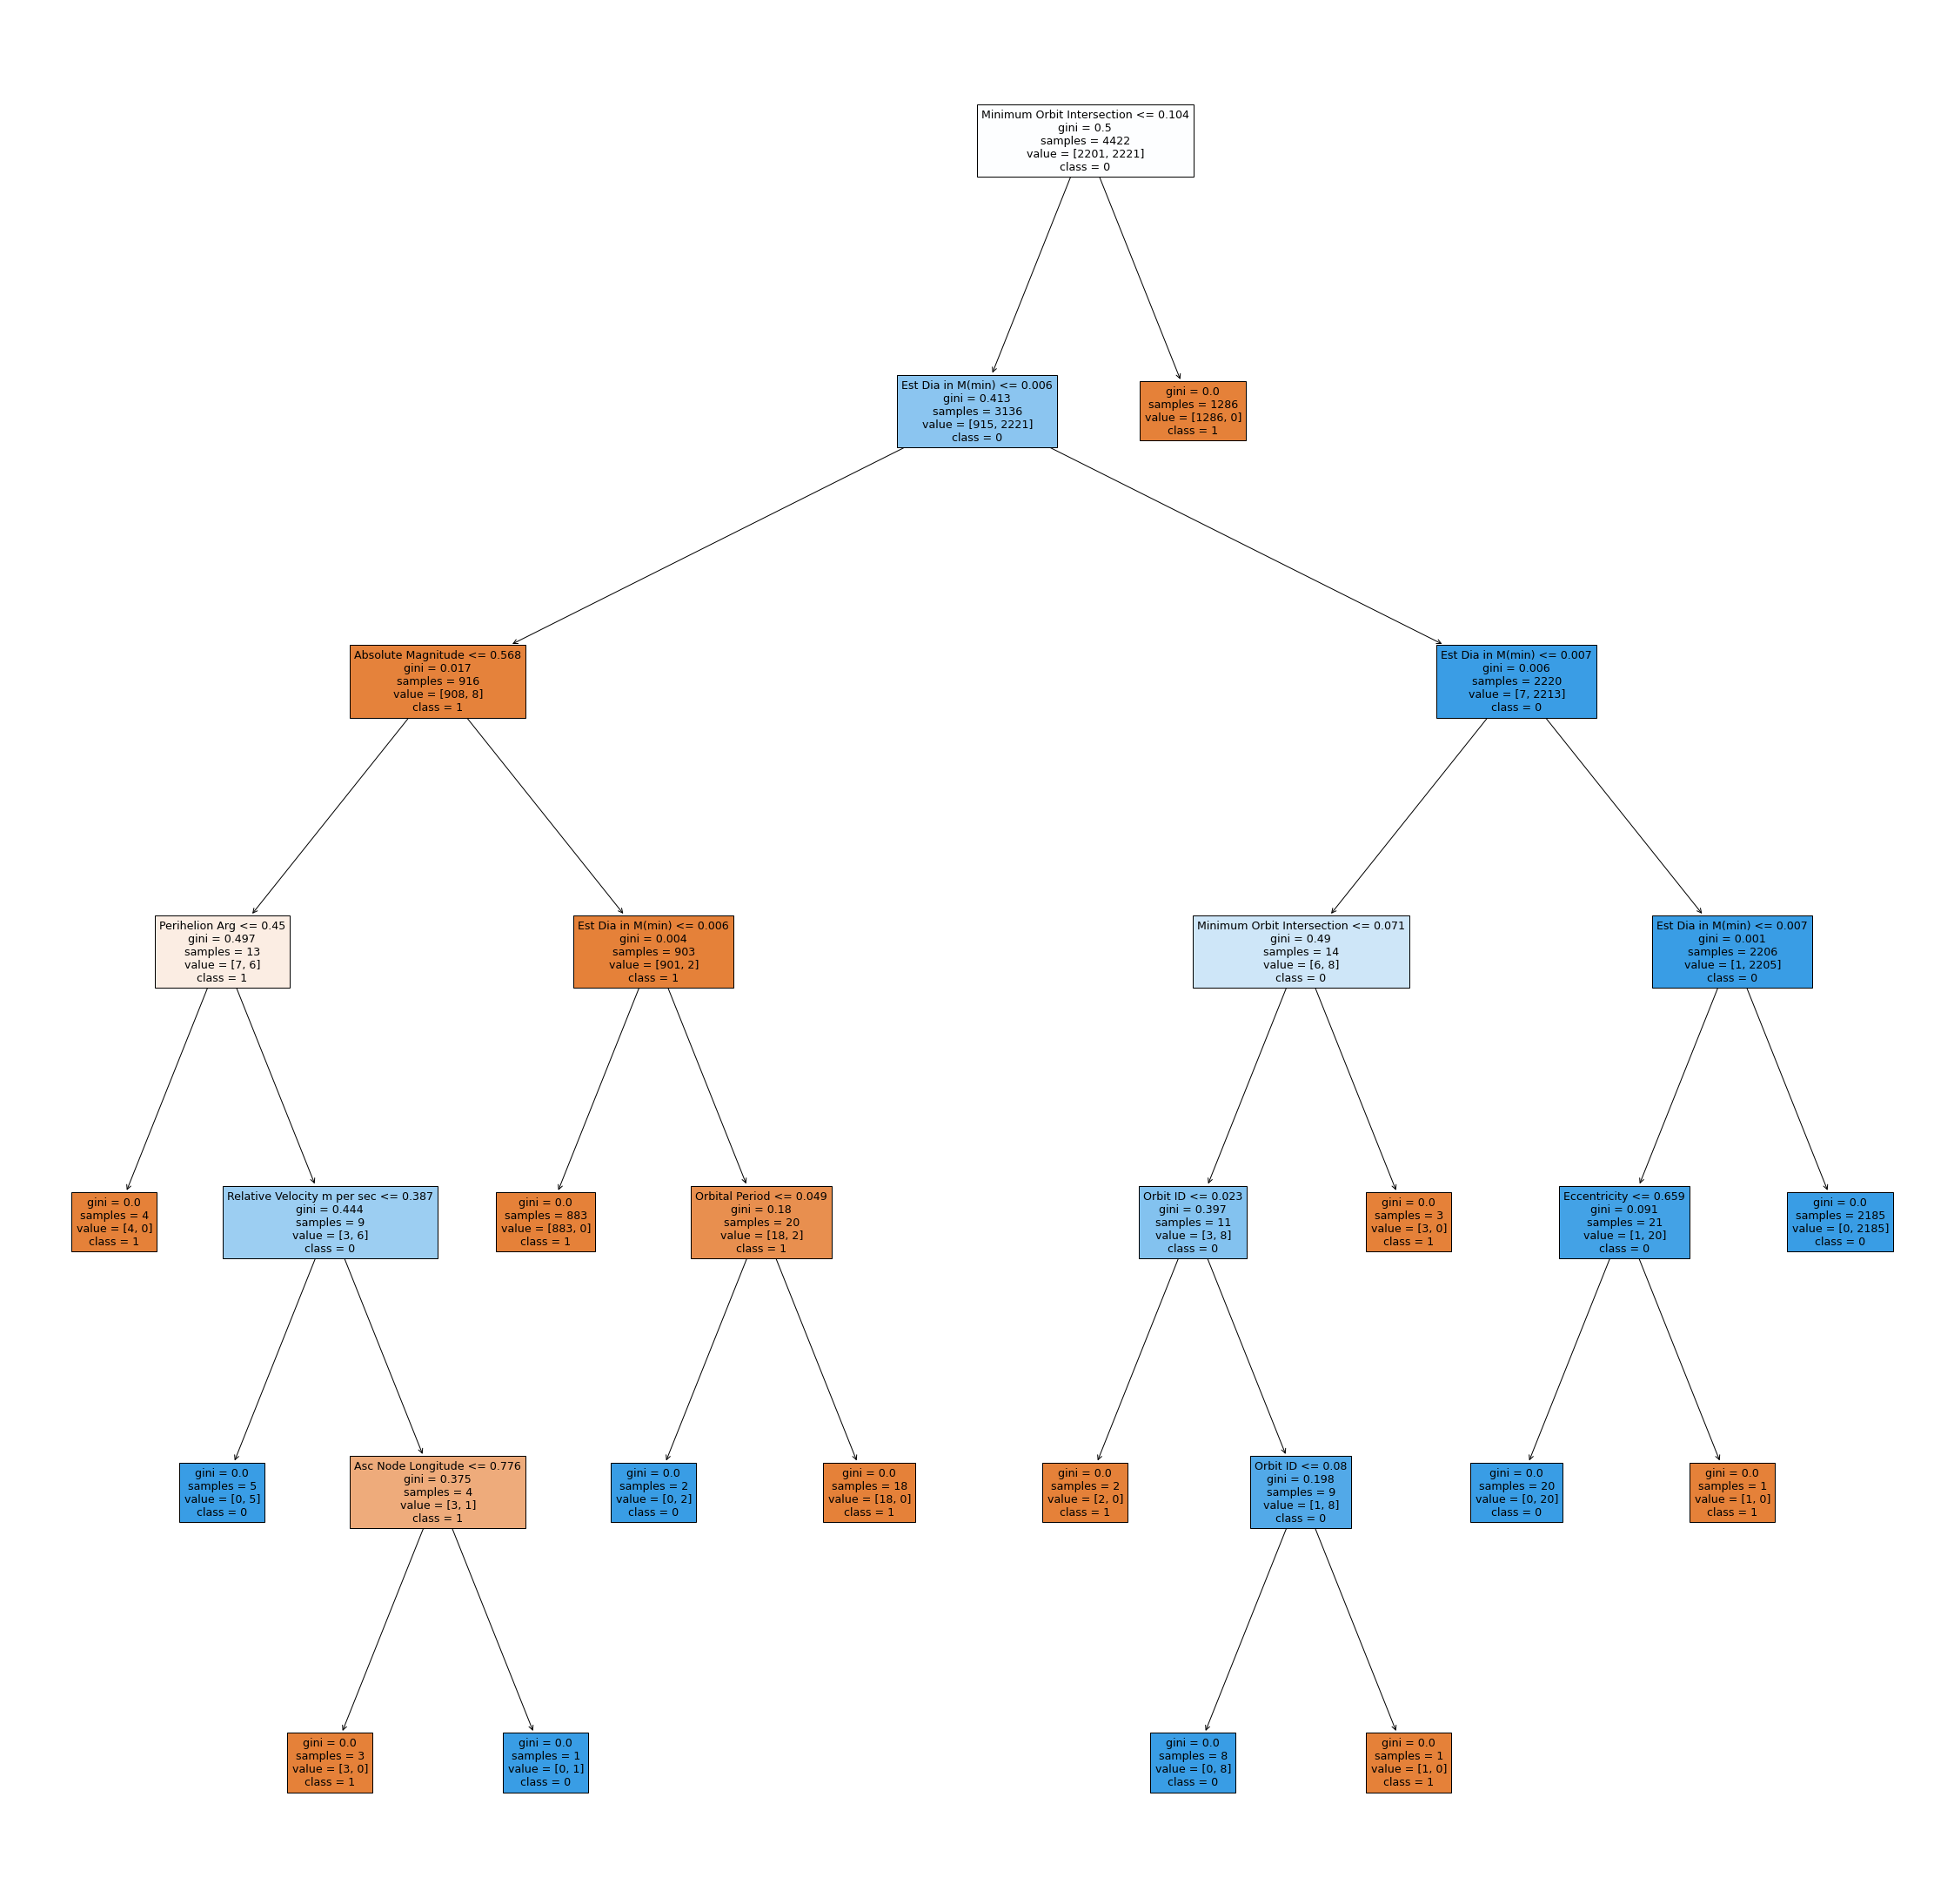

In [26]:
#Decision tree plot of data with oversampling
Y = Y_avif
Dec_tree_plot = plt.figure(figsize=(40,40))

y_class_list = []
for i in Y.tolist():
    y_class_list.append(str(i))
_ = tree.plot_tree(dec_tree, 
                   feature_names=X_avif.columns.tolist(),  
                   class_names=y_class_list,
                   filled=True)

plt.savefig("Dec_tree_plot.png")

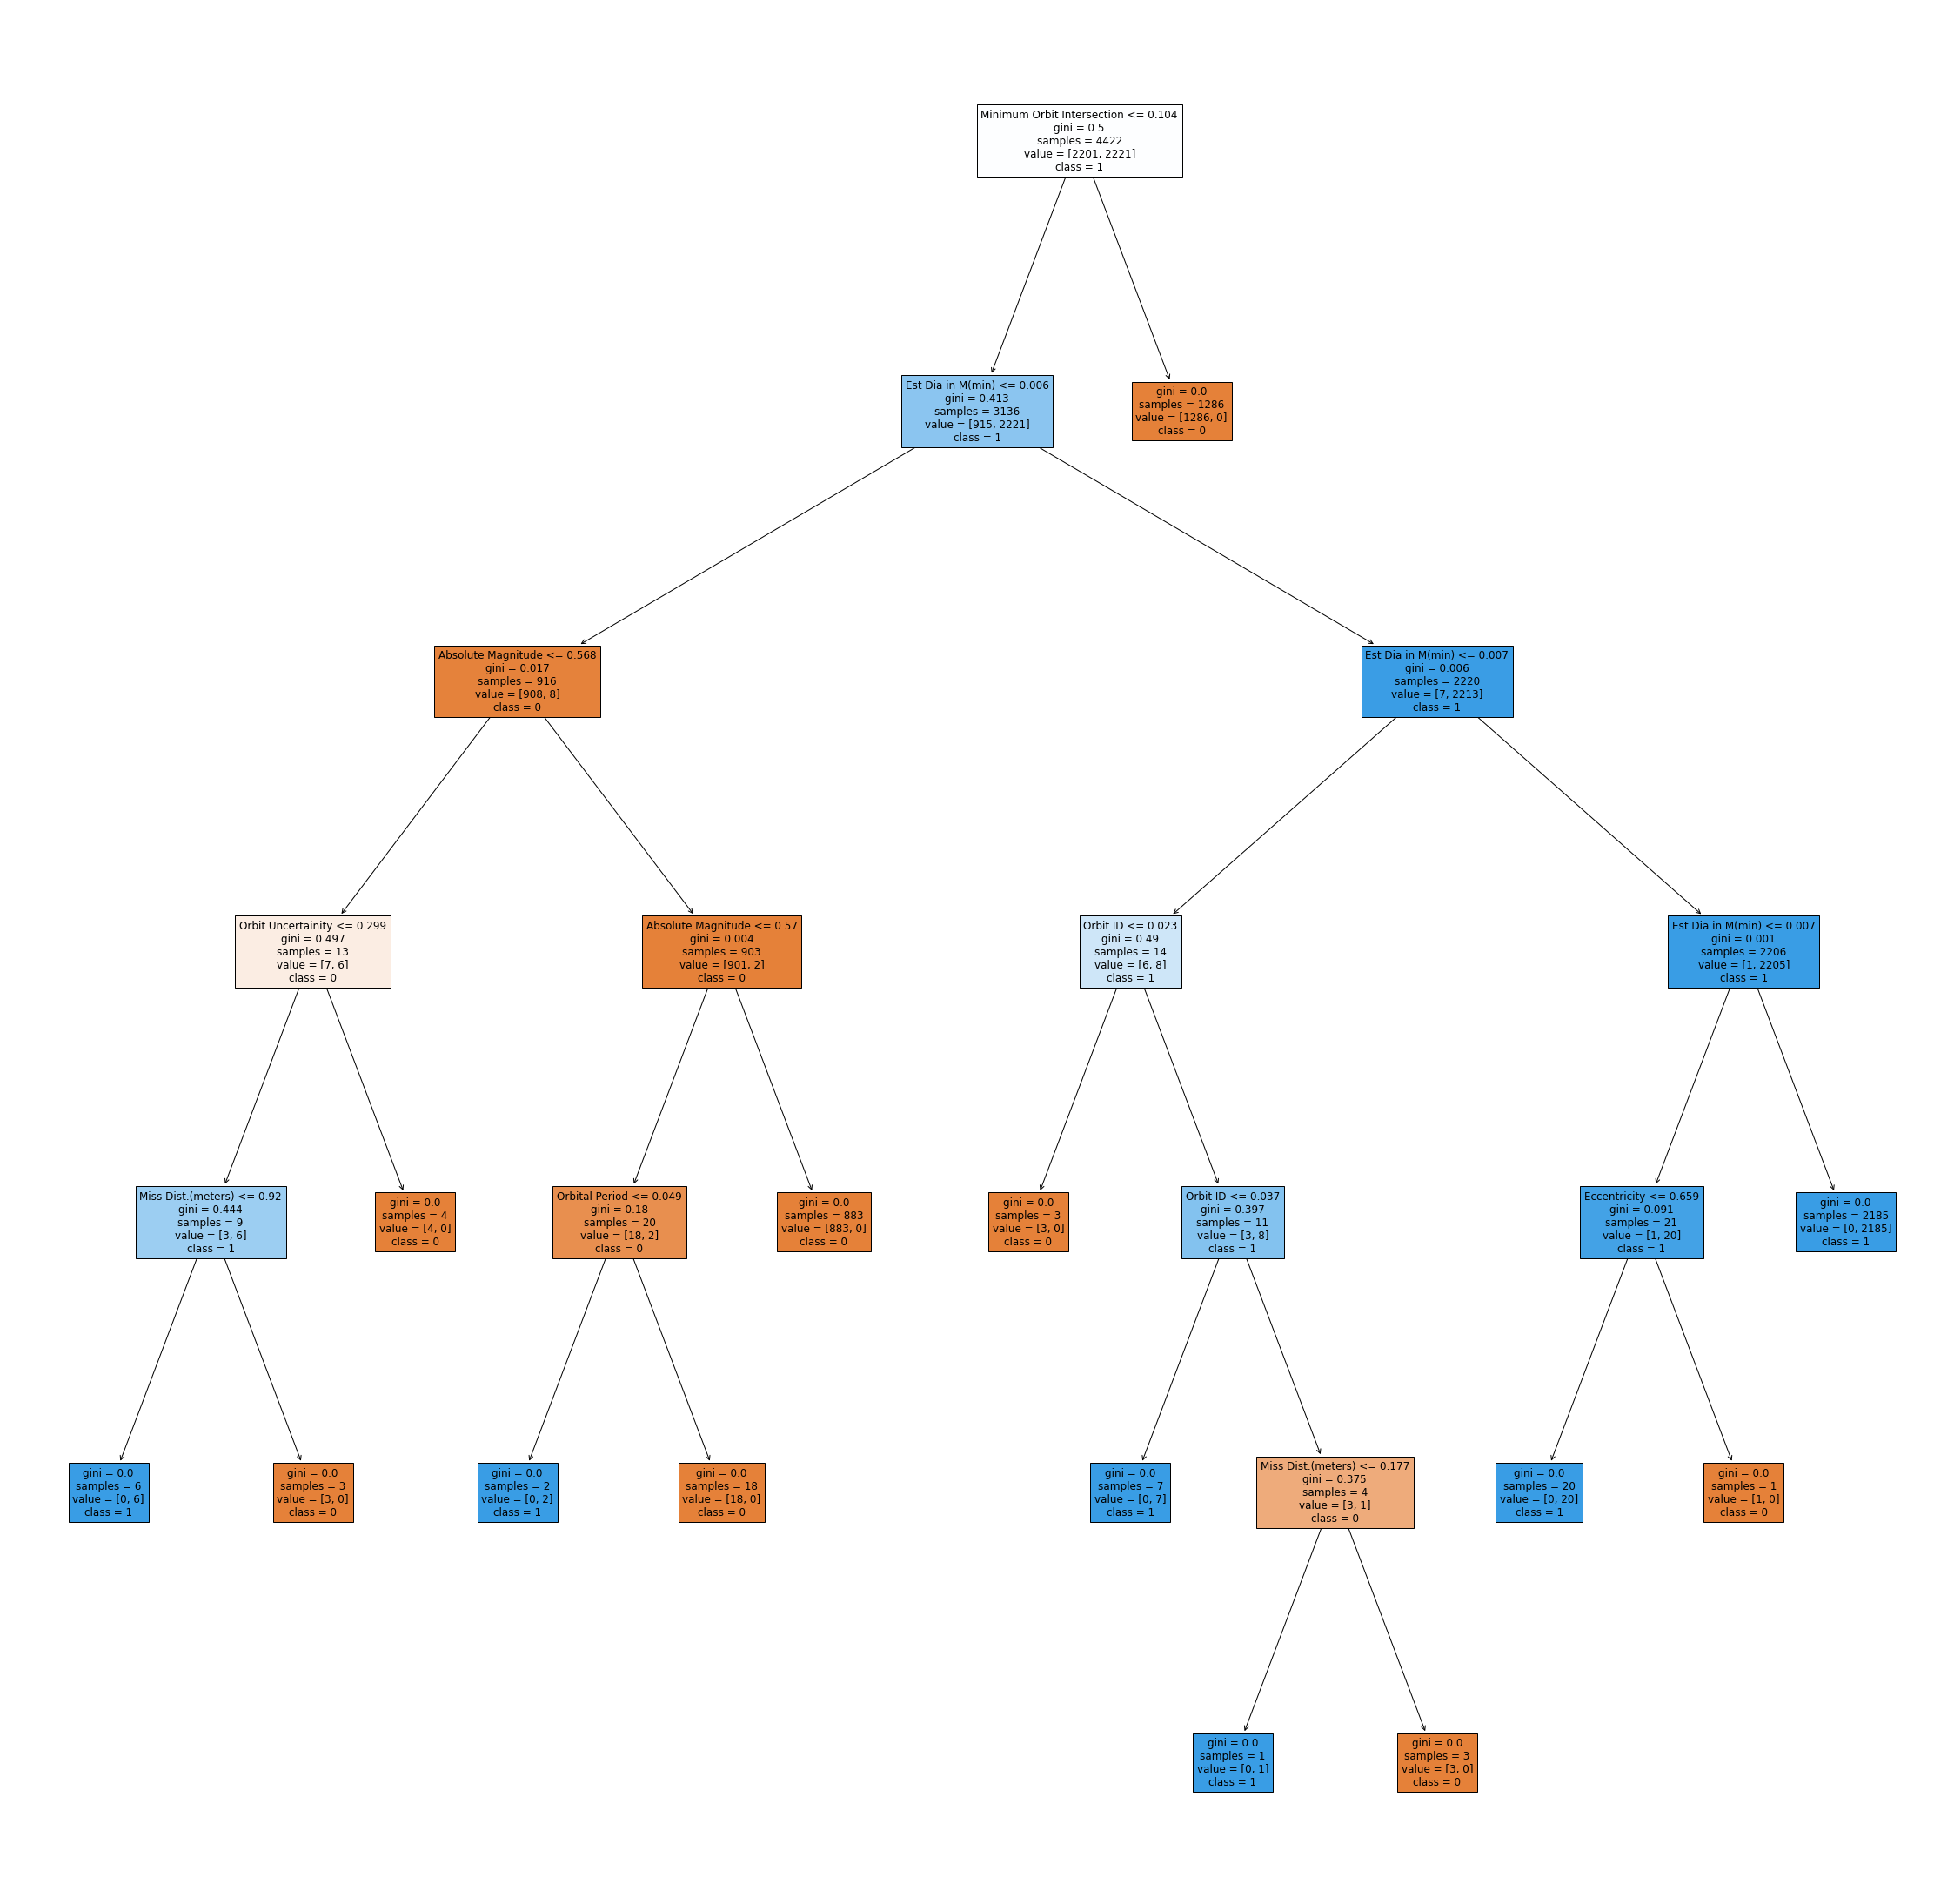

In [27]:
#Decision tree plot of data without oversampling
Dec_tree_plot_ovs = plt.figure(figsize=(40,40))
y_class_list_ovs = []

for i in y_train_ovs.tolist():
    y_class_list_ovs.append(str(i))
_= tree.plot_tree(dec_tree_ovs, 
                   feature_names=X_avif.columns.tolist(),
                   class_names=y_class_list_ovs,
                   filled=True)
plt.savefig("Dec_tree_plot_ovs.png")

**Random Forest:**

In [28]:
#Without Oversampling
dec_tree = RandomForestClassifier(max_depth=2, random_state=0)
y_pred = dec_tree.fit(X_train, y_train).predict(X_test)
#Classification report
pd.DataFrame(classification_report(y_test, y_pred, output_dict=True))

,0,1,accuracy,macro avg,weighted avg
precision,0.839590,0.0,0.83959,0.419795,0.704912
recall,1.000000,0.0,0.83959,0.500000,0.839590
f1-score,0.912801,0.0,0.83959,0.456401,0.766379
support,984.000000,188.0,0.83959,1172.000000,1172.000000


In [29]:
#Run time
start_time = time.time()
dec_tree = RandomForestClassifier(max_depth=2, random_state=0)
y_pred = dec_tree.fit(X_train, y_train).predict(X_test)
print("Run time: " + "%ss" % round((time.time() - start_time),2))

Run time: 0.54s


In [30]:
#With Oversampling
dec_tree = RandomForestClassifier(max_depth=2, random_state=0)
y_pred_ovs = dec_tree.fit(X_train_ovs, y_train_ovs).predict(X_test_ovs)
#Classification report
pd.DataFrame(classification_report(y_test_ovs, y_pred_ovs, output_dict=True))

,0,1,accuracy,macro avg,weighted avg
precision,0.997330,1.000000,0.998643,0.998665,0.998647
recall,1.000000,0.997249,0.998643,0.998624,0.998643
f1-score,0.998663,0.998623,0.998643,0.998643,0.998643
support,747.000000,727.000000,0.998643,1474.000000,1474.000000


In [31]:
#Run time   
dec_tree = RandomForestClassifier(max_depth=2, random_state=0)
y_pred_ovs = dec_tree.fit(X_train_ovs, y_train_ovs).predict(X_test_ovs)
print("Run time: " + "%ss" % round((time.time() - start_time),2))

Run time: 1.89s


**K-nearest Neighbors**

In [32]:
def eucledian_dist(p1,p2):
    dist = np.sqrt(np.sum((p1-p2)**2))
    return dist

def KNN(X_train,y_train,X_test,k):
    """
    For each test example, find K nearest training examples to it and find the most common
    class among these K_nearest training examples. Repeat the process.
    """
    X_train = np.array(X_train)
    y_train = np.array(y_train)
    X_test = np.array(X_test)
    m,n = X_train.shape
    mt,nt = X_test.shape
    y_pred = np.zeros(mt)
    distance = np.zeros(m)
    neighbor = np.zeros(k)
    for i in range(mt):
        x = X_test[i]
        for j in range(m):
            d = np.sqrt(np.sum(np.square(x - X_train[j])))
            distance[j] = d
        index = np.argsort(distance)
        y_train_sorted = y_train[index]
        neighbor = y_train_sorted[:k]
        y_pred[i] = mode(neighbor)[0][0]
    return y_pred

In [33]:
#Without Oversampling
y_pred = KNN(X_train,y_train,X_test, 10)
#Classification report
pd.DataFrame(classification_report(y_test, y_pred, output_dict=True))

,0,1,accuracy,macro avg,weighted avg
precision,0.839590,0.0,0.83959,0.419795,0.704912
recall,1.000000,0.0,0.83959,0.500000,0.839590
f1-score,0.912801,0.0,0.83959,0.456401,0.766379
support,984.000000,188.0,0.83959,1172.000000,1172.000000


In [34]:
#Run time
start_time = time.time()
y_pred = KNN(X_train,y_train,X_test, 10)
print("Run time: " + "%ss" % round((time.time() - start_time),2))

Run time: 79.39s


In [35]:
#With Oversampling
y_pred_ovs = KNN(X_train_ovs,y_train_ovs,X_test_ovs, 10)
#Classification report
pd.DataFrame(classification_report(y_test_ovs, y_pred_ovs, output_dict=True))

,0,1,accuracy,macro avg,weighted avg
precision,0.986907,0.833140,0.896879,0.910023,0.911067
recall,0.807229,0.988996,0.896879,0.898112,0.896879
f1-score,0.888071,0.904403,0.896879,0.896237,0.896126
support,747.000000,727.000000,0.896879,1474.000000,1474.000000


In [36]:
#Run time
start_time = time.time()  
y_pred_ovs = KNN(X_train_ovs,y_train_ovs,X_test_ovs, 10)
print("Run time: " + "%ss" % round((time.time() - start_time),2))

Run time: 222.17s


**XGBoost**

In [37]:
#Without Oversampling
clf = XGBClassifier(verbosity = 0)
clf.fit(np.array(X_train),np.array(y_train))
y_pred = clf.predict(np.array(X_test))
#Classification report
pd.DataFrame(classification_report(y_test, y_pred, output_dict=True))

,0,1,accuracy,macro avg,weighted avg
precision,0.839590,0.0,0.83959,0.419795,0.704912
recall,1.000000,0.0,0.83959,0.500000,0.839590
f1-score,0.912801,0.0,0.83959,0.456401,0.766379
support,984.000000,188.0,0.83959,1172.000000,1172.000000


In [38]:
#Run time
start_time = time.time()
clf = XGBClassifier(verbosity = 0)
clf.fit(np.array(X_train),np.array(y_train))
y_pred = clf.predict(np.array(X_test))
print("Run time: " + "%ss" % round((time.time() - start_time),2))

Run time: 0.77s


In [39]:
#With oversampling
clf = XGBClassifier(verbosity = 0)
clf.fit(X_train_ovs,y_train_ovs)
y_pred_ovs = clf.predict(np.array(X_test_ovs))
#Classification report
pd.DataFrame(classification_report(y_test_ovs, y_pred_ovs, output_dict=True))

,0,1,accuracy,macro avg,weighted avg
precision,0.998663,1.000000,0.999322,0.999332,0.999322
recall,1.000000,0.998624,0.999322,0.999312,0.999322
f1-score,0.999331,0.999312,0.999322,0.999321,0.999322
support,747.000000,727.000000,0.999322,1474.000000,1474.000000


In [40]:
#Run time
start_time = time.time()
clf = XGBClassifier(verbosity = 0)
clf.fit(X_train_ovs,y_train_ovs)
y_pred_ovs = clf.predict(np.array(X_test_ovs))
print("Run time: " + "%ss" % round((time.time() - start_time),2))

Run time: 0.8s


#### Comparison

 $$
\begin{aligned}
&\text {Performance of each algorithm on data with/without oversampling}\\
&\begin{array}{cccc}
\hline \hline \text { Algorithm } & \text {Accuracy } & \text { Run time (seconds) } \\
\hline \text { Logistic Regression w/o oversampling } & 0.8396 & 1.3 \\
\text { Logistic Regression w/ oversampling } & 0.7517 & 2.02 \\
\text { Naive Bayes w/o oversampling} & 0.8396 &  0.21 \\
\text { Naive Bayes w/ oversampling} & 0.9423 &  0.12 \\
\text{ Support Vector Machines w/o oversampling } & 0.8396 & 0.09 \\
\text{ Support Vector Machines w/ oversampling } & 0.8087 & 4.5 \\
\text{ Decision Tree w/o oversampling } & 0.8396 & 0.07 \\
\text{ Decision Tree w/ oversampling} & 0.9980 & 0.11 \\
\text{ Random Forest w/o oversampling} & 0.8396 & 0.54 \\
\text{ Random Forest w/ oversampling} & 0.9986 & 1.89 \\
\text{ K-nearest Neighbor w/o oversampling } & 0.8396 & 79.39 \\
\text{ K-nearest Neighbor w/ oversampling} & 0.8969 & 222.17 \\
\text{ XGBoost w/o oversampling} & 0.8396 & 0.77 \\
\text{ XGBoost w/ oversampling} & 0.9993 & 0.8 \\
\hline
\end{array}
\end{aligned}
$$